In [107]:
import os
os.sys.path.append("../")
from scripts.preliminary_analysis import *


In [108]:
from pyspark.sql import SparkSession
#  Create a Spark Session
spark = (
    SparkSession.builder.appName("Preliminary Data Analysis")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "2g")
    .getOrCreate()
)

In [109]:
path = "../data/curated"

# Preliminary Data Analysis

In this notebook, we will conduct a preliminary data analysis on the data that we cleaned or are in the process of cleaning. The following statistics/visualisations will aid us in refining our cleaning pipeline, as well as help us to better understand our variables in preparation for analysis/modelling.

## Merchants

Before we conduct any analysis, we would like tocheck in the merchant ABNs in the `merchant_fp` dataframe exist in the `merchant_info` dataframe. If such ABNs do not exist, we will remove entries in `merchant_fp` that contain those ABNs.

In [110]:
# Read merchant datasets in
merchant_info = spark.read.parquet(f"{path}/merchant_info.parquet")
merchant_fp = spark.read.parquet(f"{path}/merchant_fraud_prob.parquet")

# Merge the dataset
print(f"Number of entries before the merge: {merchant_fp.count()}")
merchant_fp = merchant_fp.join(merchant_info, on = ['merchant_abn'], how = 'inner').select('merchant_abn', 'order_datetime', 'fraud_probability')
print(f'Number of entries after the merge: {merchant_fp.count()}')

Number of entries before the merge: 114
Number of entries after the merge: 95


We can see that approximately 16% of the entries in `merchant_fp` are invalid. Now that the invalid entries are taken care of, we can go ahead and check the summary statistics. 

In [111]:
# Summary Statistics
merchant_info.select("take_rate").describe().show()
merchant_fp.select("fraud_probability").describe().show()

# Closer look at proportion of merchants with fraud prob data
print(f'Total number of merchants: {merchant_info.select("merchant_abn").distinct().count()}')
print(f'Number of merchant with fraud probability in transactions: {merchant_fp.select("merchant_abn").distinct().count()}')

+-------+-----------------+
|summary|        take_rate|
+-------+-----------------+
|  count|             4026|
|   mean|4.397575757575762|
| stddev| 1.78259536794309|
|    min|              0.1|
|    max|              7.0|
+-------+-----------------+

+-------+------------------+
|summary| fraud_probability|
+-------+------------------+
|  count|                95|
|   mean|39.517386707313456|
| stddev|16.617441988139742|
|    min| 18.21089142894488|
|    max| 91.09606847149965|
+-------+------------------+

Total number of merchants: 4026
Number of merchant with fraud probability in transactions: 48


From the summary stats of the two merchant datasets, the notable columns are `take_rate` and `fraud_probability`. The other columns are not interpretable in terms of summary stats.

Looking at the mins/maxs of both these columns, they appear to fall within a reasonable defined range. More analysis will be required to have a closer look at their distributions. (Skewed or balanced).

We can see that there are only *48* merchants with a fraud probability out of *4026* which is only about *1%*. This highlights the need to create a model to help us predict merchant fraud probability for imputation, which in turn will play a role in helping us determine which transactions are valid. 

In [112]:
from pyspark.sql import functions as F

# Examine the frequency of fraud_prob for merchants and the average fraud prob accordingly
agg_merchant_fp = merchant_fp.groupBy("merchant_abn").agg(
    F.count(F.col("merchant_abn")).alias("num_transaction_with_prob"),
    F.avg("fraud_probability").alias("avg_prob")
)
agg_merchant_fp#.filter(F.col("num_transaction_with_prob") > 1)

merchant_abn,num_transaction_with_prob,avg_prob
90568944804,3,30.72298492113958
27093785141,3,28.88064813052203
76968105359,1,68.27843632543912
19492220327,8,31.958306675667544
97884414539,1,89.79919971536573
93292821052,1,66.58725735032715
83199298021,6,31.934902970741046
43083074133,1,48.66890735193894
15157368385,1,64.2774131928303
76767266140,1,29.539733207182703


Though the table only displays the first 20 rows, it is clear that some merchants have more than one transaction with fraud probability.
On the surface, there does not seem to be a correlation between number of transactions with fraud and the average fraud prob, but this may be further explored later on. 

## Consumer

In [116]:
# Read cleaned consumer data in
consumer_fp = spark.read.parquet(f"{path}/consumer_fraud_prob.parquet")
consumer_info = spark.read.parquet(f"{path}/consumer_info.parquet")

# Merge the dataset
print(f"Number of entries before the merge: {consumer_fp.count()}")
consumer_fp = consumer_fp.join(consumer_info, on = ['consumer_id'], how = 'inner').select('consumer_id', 'order_datetime', 'fraud_probability')
print(f'Number of entries after the merge: {consumer_info.count()}')

Number of entries before the merge: 34765
Number of entries after the merge: 499999


In [118]:
# Summary statistics
consumer_fp.select("fraud_probability").describe().show()
consumer_info.groupBy("state").agg(
    F.count(F.col("consumer_id")).alias("num_consumer")
)

+-------+------------------+
|summary| fraud_probability|
+-------+------------------+
|  count|             34765|
|   mean|14.945849912240353|
| stddev| 9.397401078055374|
|    min| 8.287143531552802|
|    max| 99.24738020302328|
+-------+------------------+



state,num_consumer
NT,7764
ACT,4664
SA,54973
TAS,18878
WA,79146
QLD,72861
VIC,117525
NSW,144188


From the summary statistics above, the only column interpretable is 'fraud_probability'. 

We can see that fraud_probability is within a reasonable defined range, with a minimum of 8.28 and a maximum of about 99.24. Further discussion may be required to determine whether or not it would be beneficial to conduct outlier removal.

We can also see that most consumer are from Victoria and New South Wales. Nothern Territory seems to have the least amount of buyers

## Transactions

Summary statistic of consumers fraud probability.

In [131]:
# Read in transactions dataset
transactions = spark.read.parquet(f"{path}/transactions.parquet")

# Summary Statistics
transactions.select(F.col("dollar_value")).describe().show()

+-------+--------------------+
|summary|        dollar_value|
+-------+--------------------+
|  count|            12561377|
|   mean|  166.33982036554502|
| stddev|   520.3624254515664|
|    min|9.756658099412162E-8|
|    max|  105193.88578925544|
+-------+--------------------+



From the summary statistics observed, we can see that dollar value has a minimum of $0.00000009.

This is significantly lower than even 1 cent. Therefore, it would appear to be appropriate to consider such transaction is invalid. We decided to remove any transations with a dollar value that is less than $1.00 based on the assumption that in real life, the cheapest thing we've encounter is $1.39 (a bottle of fake coke in Aldi). However, we think it's reasonable to keep transactions with high dollar value as it might be a good indication of a fraud.

In [133]:
initial_rows =  transactions.count()
print(f'Number of rows before outlier removal: {initial_rows}')
transactions = transactions.filter(F.col("dollar_value") > 1)

final_rows = transactions.count()
print(f'Number of rows after outlier removal: {final_rows}')
print(f"Net change (%): {round( (initial_rows - final_rows)/initial_rows * 100, 2 )}")

Number of rows before outlier removal: 12561377
Number of rows after outlier removal: 12461964
Net change (%): 0.79


In [8]:
"""

avg_revenue_level = merchant_info.groupBy("revenue_level").agg(
    F.count(F.col("commission_amount")).alias("num_merchant"),
    F.sum(F.col("total_orders")).alias("total_orders"),
    F.round(F.avg(F.col("commission_amount")),2).alias("avg_commission_amount"),
    F.round(F.sum(F.col("commission_amount")),2).alias("total_commission_amount"),
)
# avg_revenue_level = avg_revenue_level.withColumn("total_commission_amount", F.format_number("total_commission_amount", 2))
avg_revenue_level.withColumns(
    {"avg_commission_amount": F.format_number("avg_commission_amount",2),
    "total_commission_amount": F.format_number("total_commission_amount",2),}
)

"""

'\n\navg_revenue_level = merchant_info.groupBy("revenue_level").agg(\n    F.count(F.col("commission_amount")).alias("num_merchant"),\n    F.sum(F.col("total_orders")).alias("total_orders"),\n    F.round(F.avg(F.col("commission_amount")),2).alias("avg_commission_amount"),\n    F.round(F.sum(F.col("commission_amount")),2).alias("total_commission_amount"),\n)\n# avg_revenue_level = avg_revenue_level.withColumn("total_commission_amount", F.format_number("total_commission_amount", 2))\navg_revenue_level.withColumns(\n    {"avg_commission_amount": F.format_number("avg_commission_amount",2),\n    "total_commission_amount": F.format_number("total_commission_amount",2),}\n)\n\n'

We can now merge the transaction with the customer and mechant fraud probabilty data

In [134]:
print(f'Number of rows before the merge: {transactions.count()}')

# join with consumer fraud prob and rename the col
transactions_fp = transactions.join(consumer_fp, on = ['consumer_id', 'order_datetime'], how='left')
transactions_fp = transactions_fp.withColumnRenamed("fraud_probability", "consumer_fp")
print(f'Number of rows after the merge with consumer fraud probability: {transactions_fp.count()}')

# Join with merchatn fraud prob and rename the col
transactions_fp = transactions_fp.join(merchant_fp, on = ['merchant_abn', 'order_datetime'], how='left')
transactions_fp = transactions_fp.withColumnRenamed("fraud_probability", "merchant_fp")
print(f'Number of rows after the merge with merchant fraud probability: {transactions_fp.count()}')
transactions_fp.limit(5)

Number of rows before the merge: 12461964


Number of rows after the merge with consumer fraud probability: 12461964


Number of rows after the merge with merchant fraud probability: 12461964


merchant_abn,order_datetime,consumer_id,dollar_value,order_id,consumer_fp,merchant_fp
63290521567,2021-08-20,404256,31.43992956224629,37f57d6b-f0b7-4e1...,NULL,NULL
21439773999,2021-08-20,1141213,108.24162524772738,2ab5856b-0e2c-44b...,NULL,NULL
17324645993,2021-08-20,341881,16.917682932055882,3d6cd2fc-cc30-480...,NULL,NULL
19618998054,2021-08-20,627512,35.808471318425646,5ce61217-f1e9-41c...,NULL,NULL
66626020312,2021-08-20,75408,34.32004607898505,dafad03e-b819-46c...,NULL,NULL


In [16]:
# Convert columns to Pandas for plotting
df_pandas = transactions.select("dollar_value", "merchant_fp", "consumer_fp").toPandas()

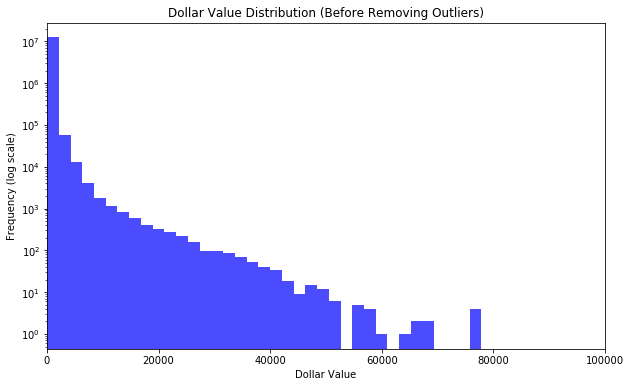

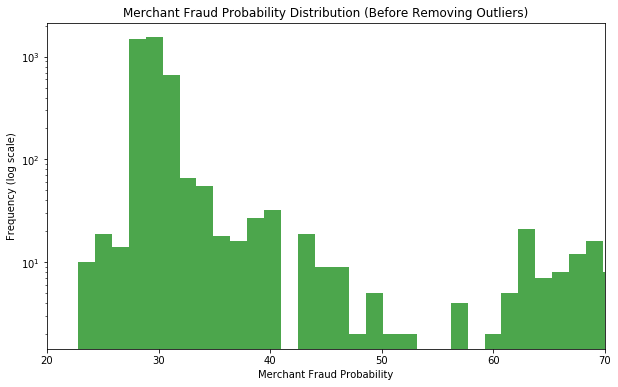

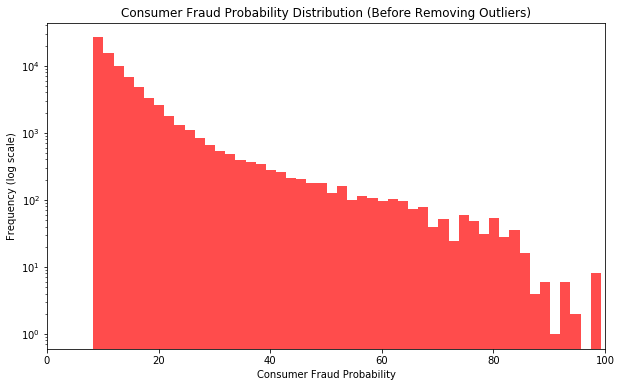

In [19]:
import matplotlib.pyplot as plt
# Plot the distribution for dollar_value with better scaling
plt.figure(figsize=(10, 6))
plt.hist(df_pandas['dollar_value'], bins=50, color='blue', alpha=0.7, log=True)  # Apply log scale to y-axis
plt.title("Dollar Value Distribution (Before Removing Outliers)")
plt.xlabel("Dollar Value")
plt.ylabel("Frequency (log scale)")
plt.xlim([0, 100000])  # Adjust x-axis limits
plt.show()

# Plot the distribution for fraud_probability (merchant) with better scaling
plt.figure(figsize=(10, 6))
plt.hist(df_pandas['merchant_fp'], bins=50, color='green', alpha=0.7, log=True)  # Apply log scale to y-axis
plt.title("Merchant Fraud Probability Distribution (Before Removing Outliers)")
plt.xlabel("Merchant Fraud Probability")
plt.ylabel("Frequency (log scale)")
plt.xlim([20, 70])  # Adjust x-axis limits
plt.show()

# Plot the distribution for fraud_probability (consumer) with better scaling
plt.figure(figsize=(10, 6))
plt.hist(df_pandas['consumer_fp'], bins=50, color='red', alpha=0.7, log=True)  # Apply log scale to y-axis
plt.title("Consumer Fraud Probability Distribution (Before Removing Outliers)")
plt.xlabel("Consumer Fraud Probability")
plt.ylabel("Frequency (log scale)")
plt.xlim([0, 100])  # Adjust x-axis limits
plt.show()


# Exploratory data analysis

# Merge Datasets

In [16]:
# Check initial dataset size
print("Original dataset:")
get_dataset_count(transactions)
print("\n")

# Join transaction_records with consumer fraud data
transaction_records_with_consumer_fraud = transactions.join(
    consumer_fp, 
    on=["consumer_id", "order_datetime"], 
    how="left"
)

print("After consumer_fp join:")

# See how the dataset size changes along the way
get_dataset_count(transaction_records_with_consumer_fraud)

# Preview
transaction_records_with_consumer_fraud.show(5)

# Check if the join led to any missing values.
calculate_missing_values(transaction_records_with_consumer_fraud)

# Join transaction records with merchant fraud data
transaction_records_with_fraud = transaction_records_with_consumer_fraud.join(
    merchant_fp, 
    on=["merchant_abn", "order_datetime"], 
    how="left"
)

print("After merchant_fp join:")

# See how the dataset size changes along the way
get_dataset_count(transaction_records_with_fraud)

# Preview
transaction_records_with_fraud.show(5)

# Check if the join led to any missing values.
calculate_missing_values(transaction_records_with_fraud)

# Join transaction records with merchant info
transaction_records_final = transaction_records_with_fraud.join(
    merchant_info, 
    on="merchant_abn", 
    how="inner"
)

print("After merchant_info join:")

# See how the dataset size changes along the way
get_dataset_count(transaction_records_final)

# Preview
transaction_records_final.show(5)

# See how the dataset size changes along the way
# Check if the join led to any missing values.
calculate_missing_values(transaction_records_final)

Original dataset:
The dataset count is  12561377


After consumer_fp join:


The dataset count is  12561589
+-----------+--------------+------------+------------------+--------------------+--------------------------+
|consumer_id|order_datetime|merchant_abn|      dollar_value|            order_id|consumer_fraud_probability|
+-----------+--------------+------------+------------------+--------------------+--------------------------+
|    1059280|    2021-11-26| 79417999332|136.06570809815838|23acbb7b-cf98-458...|                      NULL|
|    1195503|    2021-11-26| 46451548968| 72.61581642788431|76bab304-fa2d-400...|                      NULL|
|     986886|    2021-11-26| 89518629617|3.0783487174439297|a2ae446a-2959-41c...|                      NULL|
|    1195503|    2021-11-26| 49167531725| 51.58228625503599|7080c274-17f7-4cc...|                      NULL|
|     986886|    2021-11-26| 31101120643|25.228114942417797|8e301c0f-06ab-45c...|                      NULL|
+-----------+--------------+------------+------------------+--------------------+----------------

+-------------------------+----------------------------+--------------------------+--------------------------+----------------------+----------------------------------------+
|consumer_id_missing_count|order_datetime_missing_count|merchant_abn_missing_count|dollar_value_missing_count|order_id_missing_count|consumer_fraud_probability_missing_count|
+-------------------------+----------------------------+--------------------------+--------------------------+----------------------+----------------------------------------+
|                        0|                           0|                         0|                         0|                     0|                                12481029|
+-------------------------+----------------------------+--------------------------+--------------------------+----------------------+----------------------------------------+

After merchant_fp join:


The dataset count is  12561589
+------------+--------------+-----------+------------------+--------------------+--------------------------+--------------------------+
|merchant_abn|order_datetime|consumer_id|      dollar_value|            order_id|consumer_fraud_probability|merchant_fraud_probability|
+------------+--------------+-----------+------------------+--------------------+--------------------------+--------------------------+
| 79417999332|    2021-11-26|    1059280|136.06570809815838|23acbb7b-cf98-458...|                      NULL|                      NULL|
| 46451548968|    2021-11-26|    1195503| 72.61581642788431|76bab304-fa2d-400...|                      NULL|                      NULL|
| 89518629617|    2021-11-26|     986886|3.0783487174439297|a2ae446a-2959-41c...|                      NULL|                      NULL|
| 49167531725|    2021-11-26|    1195503| 51.58228625503599|7080c274-17f7-4cc...|                      NULL|                      NULL|
| 31101120643|   

+--------------------------+----------------------------+-------------------------+--------------------------+----------------------+----------------------------------------+----------------------------------------+
|merchant_abn_missing_count|order_datetime_missing_count|consumer_id_missing_count|dollar_value_missing_count|order_id_missing_count|consumer_fraud_probability_missing_count|merchant_fraud_probability_missing_count|
+--------------------------+----------------------------+-------------------------+--------------------------+----------------------+----------------------------------------+----------------------------------------+
|                         0|                           0|                        0|                         0|                     0|                                12481029|                                12557495|
+--------------------------+----------------------------+-------------------------+--------------------------+----------------------+---

The dataset count is  12047496
+------------+--------------+-----------+------------------+--------------------+--------------------------+--------------------------+--------------------+--------------------+-------------+---------+
|merchant_abn|order_datetime|consumer_id|      dollar_value|            order_id|consumer_fraud_probability|merchant_fraud_probability|                name|            category|revenue_level|take_rate|
+------------+--------------+-----------+------------------+--------------------+--------------------------+--------------------------+--------------------+--------------------+-------------+---------+
| 79417999332|    2021-11-26|    1059280|136.06570809815838|23acbb7b-cf98-458...|                      NULL|                      NULL|Phasellus At Company|gift, card, novel...|            b|     4.95|
| 46451548968|    2021-11-26|    1195503| 72.61581642788431|76bab304-fa2d-400...|                      NULL|                      NULL|Tempus Eu Ligula ...|healt

+--------------------------+----------------------------+-------------------------+--------------------------+----------------------+----------------------------------------+----------------------------------------+------------------+----------------------+---------------------------+-----------------------+
|merchant_abn_missing_count|order_datetime_missing_count|consumer_id_missing_count|dollar_value_missing_count|order_id_missing_count|consumer_fraud_probability_missing_count|merchant_fraud_probability_missing_count|name_missing_count|category_missing_count|revenue_level_missing_count|take_rate_missing_count|
+--------------------------+----------------------------+-------------------------+--------------------------+----------------------+----------------------------------------+----------------------------------------+------------------+----------------------+---------------------------+-----------------------+
|                         0|                           0|             

In [11]:
# Revenue analysis
merchant_performance = transaction_records_final.groupBy("merchant_abn").agg(
    F.sum("dollar_value").alias("total_revenue"),
    F.avg("dollar_value").alias("average_order_value"),
    F.count("dollar_value").alias("total_orders")
)

# Rank merchants by total revenue in descending order
merchant_performance = merchant_performance.orderBy(F.col("total_revenue").desc())
merchant_performance.show(10)

+------------+-----------------+-------------------+------------+
|merchant_abn|    total_revenue|average_order_value|total_orders|
+------------+-----------------+-------------------+------------+
| 39649557865| 8713454.72918194|  449.1471509887598|       19400|
| 31334588839|  8710106.7140746|  6413.922469863476|        1358|
| 27093785141|8695204.207713192|  377.1668347233969|       23054|
| 96680767841|8679874.166938104| 315.16191013173466|       27541|
| 79827781481|8657277.096810075| 2036.5271928511113|        4251|
| 32709545238|8600648.766611947|  751.2139721034105|       11449|
| 82368304209|8559519.374213614| 1865.6319473002645|        4588|
| 50315283629|8513752.395678477|  322.3685117636682|       26410|
| 90568944804|8510417.447779242|  898.9561051842444|        9467|
| 38700038932|8482176.655705512| 1337.6717640286251|        6341|
+------------+-----------------+-------------------+------------+
only showing top 10 rows



In [12]:
# Risk analysis
merchant_performance_risk = transaction_records_final.groupBy("merchant_abn").agg(
    F.avg("merchant_fraud_probability").alias("merchant_avg_fraud_prob"),
    F.avg("consumer_fraud_probability").alias("consumer_avg_fraud_prob"),
    F.sum("dollar_value").alias("total_revenue"),
    F.avg("dollar_value").alias("average_order_value"),
    F.count("dollar_value").alias("total_orders")
)

# Rank merchants by fraud probability in descending order
merchant_performance_risk = merchant_performance_risk.orderBy(F.col("merchant_avg_fraud_prob").desc())
merchant_performance_risk.show(10)

+------------+-----------------------+-----------------------+------------------+-------------------+------------+
|merchant_abn|merchant_avg_fraud_prob|consumer_avg_fraud_prob|     total_revenue|average_order_value|total_orders|
+------------+-----------------------+-----------------------+------------------+-------------------+------------+
| 35575706403|      91.09606847149965|     34.776805865701846| 806977.6688917434| 11867.318660172697|          68|
| 97884414539|      89.79919971536573|      32.40204688123495| 668322.1558769114| 11724.950103103709|          57|
| 14530561097|      80.80054474543395|      31.83820084048247|1900373.3585338441| 11379.481188825413|         167|
| 18737319630|      72.73069736562613|      9.716308521768319| 39719.82955985059|  201.6235003038101|         197|
| 85482742429|      70.88131110541714|     13.662992056430278| 34194.42789673934|  71.53646003501954|         478|
| 78080443264|      69.09531723361212|     12.295498809402012| 19336.11299420864

In [13]:
# Profitability analysis
# Calculate net revenue at the transaction level before aggregation
transaction_records_final = transaction_records_final.withColumn(
    "net_revenue", F.col("dollar_value") * F.col("take_rate")/100
)

# Aggregate net_revenue at the merchant level
merchant_profitability = transaction_records_final.groupBy("merchant_abn").agg(
    F.sum("net_revenue").alias("total_net_revenue"),
    F.sum("dollar_value").alias("total_revenue"),
    F.avg("dollar_value").alias("average_order_value"),
    F.count("dollar_value").alias("total_orders"),
    F.avg("merchant_fraud_probability").alias("merchant_avg_fraud_prob"),
    F.avg("consumer_fraud_probability").alias("consumer_avg_fraud_prob")
)

# Rank merchants by profitability in descending order
merchant_profitability.orderBy(F.col("total_net_revenue").desc()).show(10)

+------------+------------------+-----------------+-------------------+------------+-----------------------+-----------------------+
|merchant_abn| total_net_revenue|    total_revenue|average_order_value|total_orders|merchant_avg_fraud_prob|consumer_avg_fraud_prob|
+------------+------------------+-----------------+-------------------+------------+-----------------------+-----------------------+
| 79827781481| 590426.2980024472|8657277.096810075| 2036.5271928511113|        4251|     29.694380203418124|      12.77383070226627|
| 48534649627| 552231.2486106261|8316735.671846778| 141.71825290699118|       58685|     28.576898179225296|     14.902087132634948|
| 32361057556| 551286.8853157675|8340194.936698442| 109.94917852084164|       75855|                   NULL|     15.816853351282546|
| 86578477987| 542906.0687302663|8443329.218200121|  34.98505938982652|      241341|                   NULL|     15.121133124846919|
| 38700038932| 535225.3469750177|8482176.655705512| 1337.671764028625

In [18]:
merchant_info.groupBy(F.col("revenue_level")).agg(F.avg(F.col("take_rate"))) # average commission rate of each revenue level

revenue_level,avg(take_rate)
e,0.3147169811320755
d,0.9912244897959185
c,2.2512039045553167
b,4.094056254626199
a,6.232297128589269


In [ ]:
net_revenue_level = merchant_profitability.groupBy('revenue_level').sum('net_revenue') #sum up the net_revenue of BNPL firm for each level
net_revenue_level
#Data shows that make the most net_revenue from small 

In [ ]:
# Count the occurrences of each revenue level
merchant_profitability.groupBy('revenue_level').count()

In [ ]:
# Count the number of merchants with a fraud probability
fraudulent_merchants_count = merchant_profitability.filter(col("merchant_avg_fraud_prob").isNotNull()).select("merchant_abn").distinct().count()

fraudulent_merchants_count

In [ ]:
# # Compute the average fraud probability for each revenue level
average_fraud_by_revenue_level = merchant_profitability.groupBy(F.col("revenue_level")).agg(F.avg(F.col("merchant_avg_fraud_prob")).alias("merchant_avg_fraud_prob"))

# Show the results
average_fraud_by_revenue_level.show()

In [ ]:
# Compute the total number of orders for each revenue level
total_orders_by_revenue_level = merchant_profitability.groupBy(F.col("revenue_level")) \
    .agg(F.sum(F.col("total_orders")).alias("total_orders"))

# Show the results
total_orders_by_revenue_level.show()

joined_df = net_revenue_level.join(
    total_orders_by_revenue_level,
    on="revenue_level",
    how="inner"
)
joined_df = joined_df.withColumn("total_orders", F.col("total_orders").cast(DoubleType()))

# Compute the average order value
average_order_value = joined_df.withColumn(
    "avg_order_value",
    F.col("sum(net_revenue)")/ F.col("total_orders")
)

average_order_value
